In [1]:
!pip install pandas numpy matplotlib seaborn sqlalchemy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import sqlite3


In [2]:
np.random.seed(42)

n = 20000

data = pd.DataFrame({
    "job_id": np.arange(1, n+1),
    "region": np.random.choice(["North", "South", "East", "West"], n),
    "priority": np.random.choice(["Low", "Medium", "High"], n, p=[0.5,0.3,0.2]),
    "processing_time_minutes": np.random.normal(60, 15, n).round(2),
    "sla_target_minutes": 60,
    "status": np.random.choice(["Completed", "Delayed", "Failed"], n, p=[0.85,0.1,0.05]),
    "created_date": pd.date_range("2025-01-01", periods=n, freq="H")
})

# Introduce anomalies
anomaly_indices = np.random.choice(n, 200)
data.loc[anomaly_indices, "processing_time_minutes"] *= 3

data.head()


/tmp/ipython-input-3000577564.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "created_date": pd.date_range("2025-01-01", periods=n, freq="H")


,job_id,region,priority,processing_time_minutes,sla_target_minutes,status,created_date
0,1,East,Low,50.54,60,Completed,2025-01-01 00:00:00
1,2,West,Low,92.10,60,Completed,2025-01-01 01:00:00
2,3,North,Low,84.99,60,Completed,2025-01-01 02:00:00
3,4,East,Medium,70.96,60,Completed,2025-01-01 03:00:00
4,5,East,Low,54.85,60,Completed,2025-01-01 04:00:00


In [3]:
engine = create_engine("sqlite:///operations.db")
data.to_sql("operations", engine, if_exists="replace", index=False)

print("Dataset stored in SQL database.")


Dataset stored in SQL database.


In [4]:
query = """
SELECT
    COUNT(*) AS total_records,
    SUM(CASE WHEN processing_time_minutes IS NULL THEN 1 ELSE 0 END) AS null_processing_time,
    SUM(CASE WHEN processing_time_minutes < 0 THEN 1 ELSE 0 END) AS negative_processing_time
FROM operations;
"""

validation_results = pd.read_sql(query, engine)
validation_results
sla_query = """
SELECT
    COUNT(*) AS total_jobs,
    SUM(CASE WHEN processing_time_minutes > sla_target_minutes THEN 1 ELSE 0 END) AS sla_breaches
FROM operations;
"""

sla_results = pd.read_sql(sla_query, engine)
sla_results["breach_rate"] = sla_results["sla_breaches"] / sla_results["total_jobs"]

sla_results
mean = data["processing_time_minutes"].mean()
std = data["processing_time_minutes"].std()

data["z_score"] = (data["processing_time_minutes"] - mean) / std
data["anomaly_flag"] = np.where(abs(data["z_score"]) > 3, 1, 0)

anomaly_count = data["anomaly_flag"].sum()
print(f"Detected {anomaly_count} anomalies.")


Detected 183 anomalies.


In [5]:
data_quality_score = 100 - (
    (validation_results["null_processing_time"][0] / n * 100) +
    (anomaly_count / n * 100)
)

print(f"Data Quality Score: {round(data_quality_score,2)}%")


Data Quality Score: 99.08%


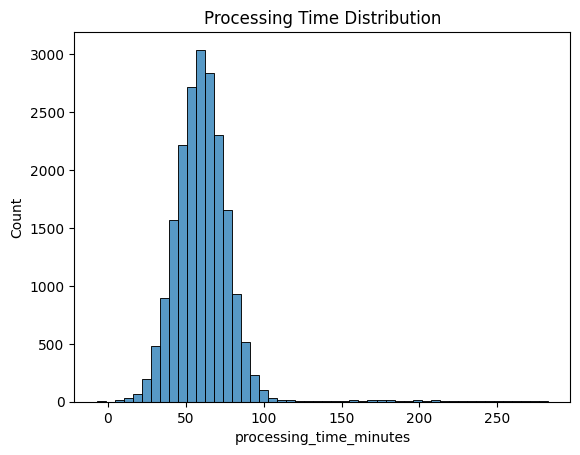

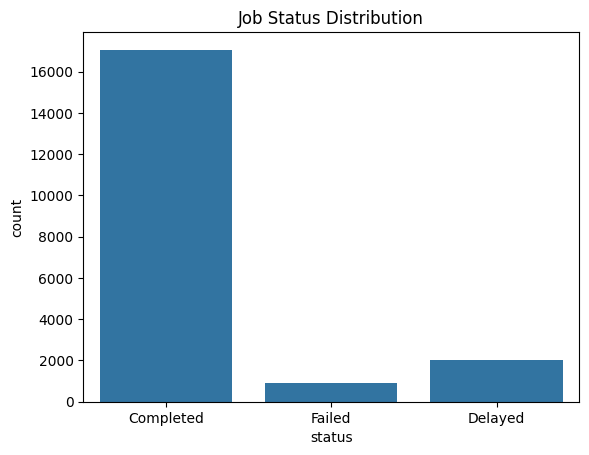

In [6]:
plt.figure()
sns.histplot(data["processing_time_minutes"], bins=50)
plt.title("Processing Time Distribution")
plt.show()
plt.figure()
sns.countplot(x="status", data=data)
plt.title("Job Status Distribution")
plt.show()


In [7]:
def risk_level(row):
    if row["anomaly_flag"] == 1 and row["status"] != "Completed":
        return "High Risk"
    elif row["processing_time_minutes"] > 90:
        return "Medium Risk"
    else:
        return "Low Risk"

data["risk_category"] = data.apply(risk_level, axis=1)

data["risk_category"].value_counts()


,count
risk_category,
Low Risk,19351
Medium Risk,618
High Risk,31
